![vl01e5grs6ca1.png](vl01e5grs6ca1.png)
source: https://www.reddit.com/r/StableDiffusion/comments/10cgxrx/wellresearched_comparison_of_training_techniques/

---

### 1. 🖼️ Dreambooth

* **Mechanism:** Dreambooth fine-tunes a **significant portion of the main Diffusion Model's weights**, primarily within the **U-Net** (the denoising backbone). It uses a small set of subject-specific images and associates them with a **unique identifier** (e.g., a token like `sks`).
* **Key Feature:** It employs a **prior-preservation loss** using general class images (e.g., generic photos of a "dog") to prevent **catastrophic forgetting** and maintain the model's understanding of the broader concept.
* **Trade-offs:**
    * **Pros:** Achieves the **highest fidelity** and identity preservation.
    * **Cons:** **Storage-intensive** (creates a new, large model checkpoint, often 2-4 GB) and requires **more VRAM** and training time.

---

### 2. 📝 Textual Inversion (Embeddings)

* **Mechanism:** This method **freezes the U-Net weights** and focuses on optimizing the **text embedding vector** within the **Text Encoder**. It learns a new, synthetic "word" (a small vector) that efficiently represents the desired concept or style in the model's latent space.
* **Key Feature:** The resulting file is an **extremely small embedding** (tens of KB) that acts as a special token in the prompt (e.g., `a photo of a <my-face-token>`).
* **Trade-offs:**
    * **Pros:** **Highly storage-efficient** and portable. Very fast to train.
    * **Cons:** Limited in capturing complex visual details or broad styles, as it only modifies the input prompt space and not the generation process itself.

---

### 3. 📉 LoRA (Low-Rank Adaptation)

* **Mechanism:** LoRA is a **PEFT** technique that freezes the original model weights and injects **small, trainable rank-decomposition weight matrices** (Matrix $A$ and Matrix $B$) into the large weight matrices of the **U-Net's cross-attention layers**.
    * The learned update is $\Delta W = A \times B$, where $A$ and $B$ have a small rank $r$ (e.g., $r=4$ or $r=8$).
* **Key Feature:** Only $A$ and $B$ are trained. The resulting LoRA "adapter" file is small (typically 8 MB to 150 MB) and can be easily applied at inference time.
* **Trade-offs:**
    * **Pros:** Excellent balance of **quality, speed, and portability**. Fast training and low VRAM requirements. Offers quality very close to Dreambooth.
    * **Cons:** May require careful tuning of the final LoRA weight (scale) during inference.

---

### 4. 🧠 Hypernetworks

* **Mechanism:** A Hypernetwork is a **separate, small neural network** that is trained to generate the weights for a specific subset of the U-Net layers (typically the attention or convolution layers). During training/inference, the generated weights overwrite a portion of the main model's weights.
* **Key Feature:** The Hypernetwork itself is a small file, providing a compressed representation of the learned style or concept.
* **Trade-offs:**
    * **Pros:** Compact file size. Good for learning specific visual styles.
    * **Cons:** Generally **less prevalent and less stable** than LoRA in current community usage. The indirect nature of weight generation can make optimization challenging.

---

### 🔬 Conclusion

**LoRA** has emerged as the most favored PEFT method for Diffusion Models due to its superior efficiency, speed, and quality balance. **Dreambooth** remains the benchmark for maximum fidelity, while **Textual Inversion** is useful for simple concept embedding where file size is the primary constraint. **Hypernetworks** and **LoRA** offer complementary approaches, with LoRA being more widely adopted for its practical benefits.

In [1]:
import numpy as np
import torch
from pathlib import Path
from diffusers.utils import load_image
from PIL import Image
from tqdm.auto import tqdm
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
from diffusers import StableDiffusionPipeline,DDIMScheduler

device = 'cuda' if torch.cuda.is_available() else 'cpu'

c:\Users\User\miniconda3\envs\torch_env\lib\site-packages\triton\knobs.py:212: UserWarning: Failed to find cuobjdump.exe
  warnings.warn(f"Failed to find {binary}")
c:\Users\User\miniconda3\envs\torch_env\lib\site-packages\triton\knobs.py:212: UserWarning: Failed to find nvdisasm.exe
  warnings.warn(f"Failed to find {binary}")


In [2]:
model_id = 'stable-diffusion-v1-5/stable-diffusion-v1-5'
pipeline = StableDiffusionPipeline.from_pretrained(model_id,
                                                    safety_checker=None, 
                                                    torch_dtype=torch.float16).to(device)

pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

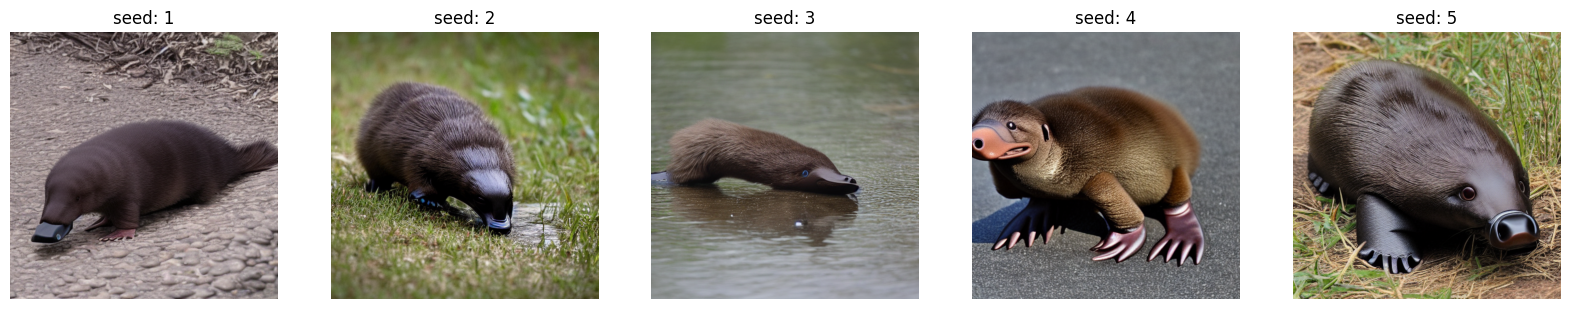

In [4]:
gen_images=[]
seeds = [1,2,3,4,5]
for seed in seeds:
    gen_image = pipeline(
                        prompt="platypus",
                        guidance_scale=8,
                        num_inference_steps=25,
                        height=512,
                        width=512,
                        cross_attention_kwargs={"scale": 0.0},
                        generator=torch.manual_seed(seed)
                    ).images[0]

    gen_images.append(gen_image)
    

fig,axes = plt.subplots(1,5,figsize=(20,10))
for i,ax in enumerate(axes):
    ax.imshow(gen_images[i])
    ax.set_title(f"seed: {seeds[i]}")
    ax.axis('off')
plt.show()

# Load LoRA weights

In [3]:
pipeline.load_lora_weights(
    "Mohan-diffuser/lora_platypus_sd_15",
)
# link: https://huggingface.co/Mohan-diffuser/lora_platypus_sd_15

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/25 [00:00<?, ?it/s]

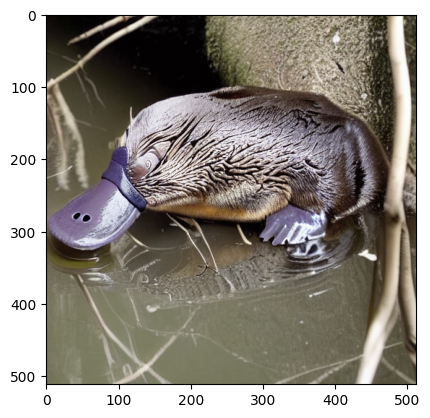

In [4]:
gen_image = pipeline(
    prompt="platypus",
    guidance_scale=8,
    num_inference_steps=25,
    height=512,
    width=512,
    cross_attention_kwargs={"scale": 0.8},
    generator=torch.manual_seed(42)
).images[0]

plt.imshow(gen_image)
plt.show()

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

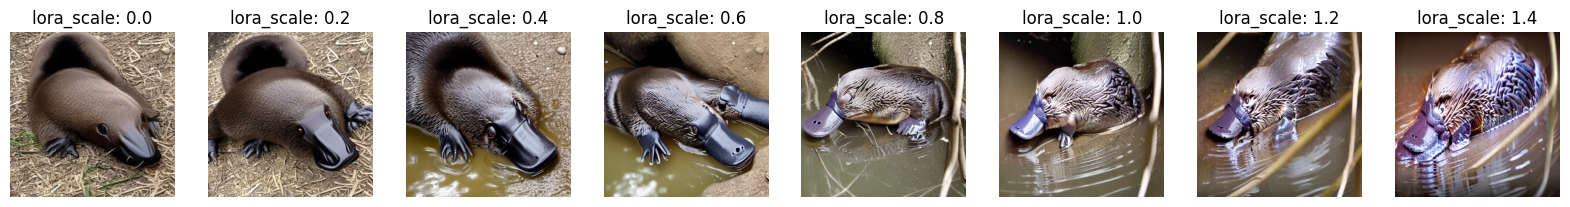

In [7]:
gen_images=[]
lora_scales = [.00,0.2,0.4,0.6,0.8,1.0,1.2,1.4]
for lora_scale in lora_scales:
    gen_image = pipeline(
                        prompt="platypus",
                        guidance_scale=8,
                        num_inference_steps=25,
                        height=512,
                        width=512,
                        cross_attention_kwargs={"scale": lora_scale},
                        generator=torch.manual_seed(42)
                    ).images[0]

    gen_images.append(gen_image)
    

fig,axes = plt.subplots(1,8,figsize=(20,10))
for i,ax in enumerate(axes):
    ax.imshow(gen_images[i])
    ax.set_title(f"lora_scale: {lora_scales[i]}")
    ax.axis('off')
plt.show()

# Textual Inversion

In [5]:
pipeline.load_textual_inversion("verybadimagenegative_v1.3.pt")
pipeline.load_textual_inversion("EasyNegativeV2.safetensors")
pipeline.load_textual_inversion("ng_deepnegative_v1_75t.pt")


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

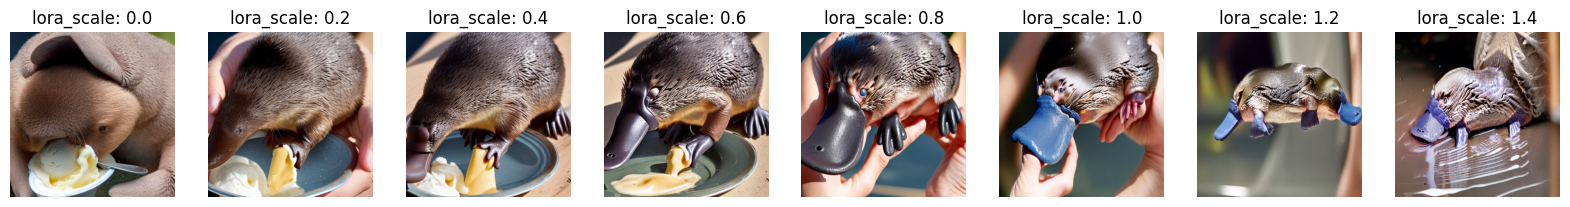

In [7]:
gen_images=[]
lora_scales = [0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4]
for lora_scale in lora_scales:
    gen_image = pipeline(
                        prompt="platypus, eating icecream",
                        # negative_prompt="ng_deepnegative_v1_75t, verybadimagenegative_v1.3,  EasyNegativeV2",
                        guidance_scale=7,
                        num_inference_steps=25,
                        height=512,
                        width=512,
                        cross_attention_kwargs={"scale": lora_scale},
                        generator=torch.manual_seed(42)
                    ).images[0]

    gen_images.append(gen_image)
    

fig,axes = plt.subplots(1,8,figsize=(20,10))
for i,ax in enumerate(axes):
    ax.imshow(gen_images[i])
    ax.set_title(f"lora_scale: {lora_scales[i]}")
    ax.axis('off')
plt.show()